# NoSQL (HBase) (sesión 6)

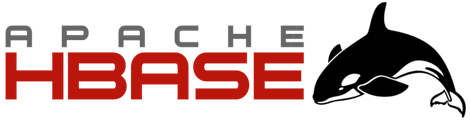

Esta hoja muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

Se puede utilizar el *shell* propio de HBase en el contenedor.

Con HBase vamos a simular un _clúster_ de varias máquinas con varios contenedores conectados. En el directorio `hbase` del repositorio git hay un script para ejecutar la instalación con `docker-compose`.

Para conectarse al _clúster_ con un _shell_ de hbase, hay que ejecutar, desde una terminal el siguiente comando de docker:

    $ docker exec -ti regionserver-1 hbase shell
    Base Shell; enter 'help<RETURN>' for list of supported commands.
    Type "exit<RETURN>" to leave the HBase Shell
    Version 1.2.7, rac57c51f7ad25e312b4275665d62b34a5945422f, Fri Sep  7 16:11:05 CDT 2018

    hbase(main):001:0> 


In [ ]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `happybase` para python. La cargamos a continuación y hacemos la conexión.

In [ ]:
!pip install happybase

In [ ]:
import happybase

host = 'hbasethrift-1.vnet'
connection = happybase.Connection(host)
connection.tables()

Para la carga inicial, vamos a crear todas las tablas con una única familia de columnas, `rawdata`, donde meteremos toda la información _raw_ comprimida. Después podremos hacer reorganizaciones de los datos para hacer el acceso más eficiente. Es una de las muchas ventajas de no tener un esquema.

In [ ]:
%%bash
file=../Posts.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
%%bash
file=../Users.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
%%bash
file=../Tags.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
%%bash
file=../Comments.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
%%bash
file=../Votes.csv
test -e $file || wget http://neuromancer.inf.um.es:8080/es.stackoverflow/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
# Create tables
tables = ['posts', 'votes', 'users', 'tags', 'comments']
for t in tables:
    try:
        connection.create_table(
            t,
            {
                'rawdata': dict(max_versions=1,compression='GZ')
            })
    except:
        print("Database already exists: {0}.".format(t))
        pass
connection.tables()

El código de importación es siempre el mismo, ya que se coge la primera fila del CSV que contiene el nombre de las columnas y se utiliza para generar nombres de columnas dentro de la familia de columnas dada como parámetro. La función `csv_to_hbase()` acepta un fichero CSV a abrir, un nombre de tabla y una familia de columnas donde agregar las columnas del fichero CSV. En nuestro caso siempre va a ser `rawdata`.

In [ ]:
import csv

def csv_to_hbase(file, tablename, cf):
    table = connection.table(tablename)
    
    with open(file) as f:
        # La llamada csv.reader() crea un iterador sobre un fichero CSV
        reader = csv.reader(f, dialect='excel')
        
        # Se leen las columnas. Sus nombres se usarán para crear las diferentes columnas en la familia
        columns = next(reader)
        columns = [cf + ':' + c for c in columns]
        
        with table.batch(batch_size=500) as b:
            for row in reader:
                # La primera columna se usará como Row Key
                b.put(row[0], dict(zip(columns[1:], row[1:])))

In [ ]:
for t in tables:
    print("Importando tabla {0}...".format(t))
    %time csv_to_hbase('../'+t.capitalize() + '.csv', t, 'rawdata')

### Consultas sencillas desde Python

A continuación veremos algunas consultas sencillas desde python usando el API de `happybase`.

In [ ]:
posts = connection.table('posts')

Obtener el Post con `Id` 5. La orden más sencilla e inmediata de HBase es obtener una fila, opcionalmente limitando las columnas a mostrar:

In [ ]:
posts.row(b'5',columns=[b'rawdata:Body'])

El siguiente código permite mostrar de forma amigable las tablas extraídas de la base de datos en forma de diccionario:

In [ ]:
# http://stackoverflow.com/a/30525061/62365
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        htmltext = ["<table width=100%>"]
        for key, value in self.items():
            htmltext.append("<tr>")
            htmltext.append("<td>{0}</td>".format(key.decode('utf-8')))
            htmltext.append("<td>{0}</td>".format(value.decode('utf-8')))
            htmltext.append("</tr>")
        htmltext.append("</table>")
        return ''.join(htmltext)

In [ ]:
# Muestra cómo queda la fila del Id del Post 9997
DictTable(posts.row(b'5'))

In [ ]:
DictTable(posts.row(b'5',columns=[b'rawdata:AnswerCount',b'rawdata:AcceptedAnswerId']))

Y también se puede recorrer como un diccionario normal (el `decode` se utiliza para convertir los valores binarios de la base de datos a una codificación UTF-8):

In [ ]:
row = posts.row(b'5')
for key, value in row.items():
    print("Key = '%s', Value = '%s'" %(key,value.decode('utf-8')[:40]))

Finalmente, también se puede recorrer toda la tabla estableciendo filtros, que se estudiarán después. Se utiliza la función `scan`. Se puede iterar con los parámetros `key` y `data`. Por ejemplo, calcular el tamaño máximo de la longitud del texto de los posts:

**(OJO, es un ejemplo, no se debería hacer así)**

In [ ]:
max_len = 0
for key, data in posts.scan():
    cur_len = len(data[b'rawdata:Body'].decode('utf-8'))
    if cur_len > max_len:
        max_len = cur_len

print("Máxima longitud: %s caracteres." % (max_len))

### Construcción de estructuras anidadas

Al igual que pasaba con MongoDB, las bases de datos NoSQL como en este caso HBase permiten almacenar estructuras de datos complejas. En nuestro caso vamos a agregar los comentarios de cada pregunta o respuesta (post) en columnas del mismo. Para ello, creamos una nueva familia de columnas `comments`.

HBase es bueno para añadir columnas sencillas, por ejemplo que contengan un valor. Sin embargo, si queremos añadir objetos complejos, tenemos que jugar con la codificación de la familia de columnas y columna.

Usaremos el shell porque `happybase` no permite alterar tablas ya creadas.

En el `shell` de HBase pondremos lo siguiente:

```
disable 'posts'
alter 'posts', {NAME => 'comments', VERSIONS => 1}
enable 'posts'
```

Cada comentario que añadimos contiene, al menos:

- un id único
- un texto
- un autor
- etc.

¿Cómo se consigue meterlo en una única familia de columnas?

Hay varias formas. La que usaremos aquí, añadiremos el **id** de cada comentario como parte del nombre de la columna. Por ejemplo, el comentario con Id 2000, generará las columnas:

- `Id_2000` (valor 2000)
- `UserId_2000`
- `PostId_2000`
- `Text_2000`

con sus correspondientes valores. Así, todos los datos relativos al comentario con Id original 2000, estarán almacenados en todas las columnas que terminen en "`_2000`". La base de datos permite implementar filtros que nos permiten buscar esto de forma muy sencilla. Los veremos después.

In [ ]:
comments = connection.table('comments')
posts = connection.table('posts')

with posts.batch(batch_size=500) as bp:
    # Hacer un scan de la tabla
    for key, data in comments.scan():
        comment = {'comments:' +
                   d.decode('utf-8').split(':')[1] + "_" +
                   key.decode('utf-8') : 
                   data[d].decode('utf-8') for d in data.keys()}
        bp.put(data[b'rawdata:PostId'], comment)

In [ ]:
%%bash
file=../eswiki.xml
test -e $file || wget http://neuromancer.inf.um.es:8080/wikipedia/`basename ${file}`.gz -O - 2>/dev/null | gunzip > $file

In [ ]:
!head -200 ../eswiki.xml

Se crea la tabla para albergar la `wikipedia`. Igual que la vista en teoría, pero aquí se usa `wikipedia` en vez de `wiki` para que no colisionen la versión completa con la reducida.

De nuevo en el `shell` de HBase:

```
create 'wikipedia' , 'text', 'revision'
disable 'wikipedia' # Para evitar su uso temporal
alter 'wikipedia' , { NAME => 'text', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'revision', VERSIONS => org.apache.hadoop.hbase.HConstants::ALL_VERSIONS }
alter 'wikipedia' , { NAME => 'text', COMPRESSION => 'GZ', BLOOMFILTER => 'ROW'}
enable 'wikipedia' 
```

Este código, visto en teoría, recorre el árbol XML construyendo documentos y llamando a la función `callback` con cada uno. Los documentos son diccionarios con las claves encontradas dentro de los tags `<page>...</page>`.

In [ ]:
import xml.sax
import re

class WikiHandler(xml.sax.handler.ContentHandler):

    def __init__(self):
        self._charBuffer = ''
        self.document = {}

    def _getCharacterData(self):
        data = self._charBuffer
        self._charBuffer = ''
        return data

    def parse(self, f, callback):
        self.callback = callback
        xml.sax.parse(f, self)

    def characters(self, data):
        self._charBuffer = self._charBuffer + data

    def startElement(self, name, attrs):
        if name == 'page':
        # print 'Start of page'
            self.document = {}
        if re.match(r'title|timestamp|username|comment|text', name):
            self._charBuffer = ''

    def endElement(self, name):
        if re.match(r'title|timestamp|username|comment|text', name):
            self.document[name] = self._getCharacterData()
            # print(name, ': ', self.document[name][:20])
        if 'revision' == name:
            self.callback(self.document)


El codigo a continuación, cada vez que el código anterior llama a la función `processdoc()` se añade un documento a la base de datos.

In [ ]:
import time

class FillWikiTable():
    """Llena la tabla Wiki"""
    def __init__(self):
        # Conectar a la base de datos a través de Thrift
        self.table = connection.table('wikipedia')

    def run(_s):
        def processdoc(d):
            print("Callback called with {0}".format(d['title']))
            tuple_time = time.strptime(d['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
            timestamp = int(time.mktime(tuple_time))
            _s.table.put(d['title'],
                         {'text:': d.get('text',''),
                          'revision:author': d.get('username',''),
                          'revision:comment': d.get('comment','')},
                         timestamp=timestamp)

        with open('../eswiki.xml','r') as f:
            start = time.time()
            WikiHandler().parse(f, processdoc)
            end = time.time()
            print ("End adding documents. Time: %.5f" % (end - start))

In [ ]:
FillWikiTable().run()

El código a continuación permite ver las diferentes versiones de una revisión. Como la versión reducida es muy pequeña no da lugar a que haya ninguna revisión, pero con este código se vería. Hace uso del _shell_ de HBase:

    get 'wikipedia', 'Commodore Amiga', {COLUMN => 'revision',VERSIONS=>10}

In [ ]:
wikipedia = connection.table('wikipedia')

In [ ]:
for key,data in wikipedia.scan(columns=['revision'], row_start='A', row_stop='B', limit=10):
    print(key,'->',data)

La siguiente consulta no poduce resultados. ¿Por qué?

In [ ]:
for key,data in wikipedia.scan(columns=['revision'], row_start='A', row_stop='B',
                               filter="PrefixFilter('B')",
                               limit=10):
    print (key,'->',data)

En los siguientes ejercicios, usando `happybase`, utiliza o bien `scan` o bien `row` donde sea conveniente:

## EJERCICIO: Mostrar la familia de columnas `revision` para la entrada `ASCII` de la tabla `wikipedia`.

## EJERCICIO: Mostrar las 20 primeras filas de la tabla `wikipedia` cuyas columnas empiecen por 'com'.

## EJERCICIO: Mostrar las 20 primeras filas de la tabla `wikipedia` cuyas columnas empiecen por 'com' y la clave de fila empieza por 'B'.

## EJERCICIO: Mostrar sólo la columna `revision:author` de las filas de la tabla `wikipedia` cuya clave empiece por `a` y termine por `a` (obviando mayúsculas y minúsculas).

## EJERCICIO: Mostrar las filas de la tabla `wikipedia` cuya clave contenga al menos un número.

## EJERCICIO: Mostrar las filas de la tabla `wikipedia` cuyo autor de revisión sea `Addbot`.

## EJERCICIO: Mostrar las filas de la tabla `wikipedia` tales que alguno de sus valores de campos de columnas sea menor que 1.

## EJERCICIO: Mostrar las filas de la tabla `users` (sólo la columna `rawdata:Location`) de usuarios de España (se supondrá que su localización (columna `rawdata:Location`) contiene `España` o `ES`, obviando mayúsculas y minúsculas).

## EJERCICIO: Comparar si hay más usuarios de Santiago de Compostela que de Murcia :).

## EJERCICIO: Mostrar las filas de la tabla `posts` que hacen referencia al tag "clojure".

## EJERCICIO (opcional): Crear una nueva tabla `poststags` que, de forma eficiente, para cada _tag_, liste los `Id` de los posts que utilizan ese _tag_.

*Nota: El código de ejemplo para separar todas las etiquetas del campo Tags de un post está en la sesión 1.*